Enter the `correlation_id` you're interested in, and also the HUMIO Repo between `sb-demo`for DEMO and `sb-production` for PROD.

In [108]:
correlation_id = "4f312a349f79319f959ea18e9721b93b" # @param {"type":"string"}
repo = "sb-demo" # @param ["sb-demo","sb-production"]
start = "12h" # @param ["3h","12h","1d","7d","30d"]

# Graph generation

In [109]:
import sys
!{sys.executable} -m pip install humiolib --quiet

from humiolib.HumioClient import HumioClient

query = f"join({{{correlation_id} class=* service=*}}, field=correlation_id)"

print(query)

client = HumioClient(
    base_url= "https://cloud.humio.com",
    repository= repo,
    user_token="DbkgsKDLb52916577QxFa3Ec~lhx3YQYKnaQyvXQO8XcRtFG0T63ZuOEBwjW2OAh3pvp9")

queryjob = client.create_queryjob(query, is_live=False, start="12h")

event_map = {}
events = []

for poll_result in queryjob.poll_until_done():
    for event in poll_result.events:
        events.append(event)
        if event["correlation_id"] not in event_map:
            event_map[event["correlation_id"]] = []
        event_map[event["correlation_id"]].append(event)

correlation_id_list = list(event_map.keys())

print(f"Found {len(events)} log entries")


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
join({4f312a349f79319f959ea18e9721b93b class=* service=*}, field=correlation_id)
Found 14 log entries


In [110]:
!{sys.executable} -m pip install graphviz --quiet

import uuid
from graphviz import Digraph
from typing import List

def format_stacktrace(message: str) -> str:
    stacktrace = []
    for line in message.split("\n"):
        if line.strip().startswith("at "):
            if "com.starlingbank" in line:
                stacktrace.append(line)
            elif len(stacktrace) > 0 and stacktrace[-1] != "...":
                stacktrace.append("...")
        else:
            stacktrace.append(line)
    return "\n".join(stacktrace)

class Node:
    # Takes a Java class name and returns the class name without the package name
    @staticmethod
    def _class_name(class_name):
        if "." in class_name:
            components = class_name.split(".")
            class_name = f"{components[- 1]}"
        return class_name

    def stacktrace(self):
      return format_stacktrace(self.message)

    def _package_name(self, class_name):
        if "." in class_name:
            components = class_name.split(".")
            package = ".".join(components[:-1])
            return package
        else:
          return ""

    def __init__(self, event):
        self.id = str(uuid.uuid4())
        if "class" in event:
            self.className = self._class_name(event["class"])
            self.packageName = self._package_name(event["class"])
        else:
            self.className = "Unknown"
            self.packageName = "unknown"

        if "level" in event:
            self.level = event["level"]
        else:
            self.level = "INFO"

        self.timestamp = event["@timestamp"]
        self.message = event["message"]
        self.service = event["service"]
        self.group = event["engineering_group"].lower()
        self.correlation_id = event["correlation_id"]

    def label(self):
        return f"""<
        <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0">
        <TR><TD ALIGN="CENTER"><FONT POINT-SIZE="8">{self.packageName}</FONT></TD></TR>
        <TR><TD ALIGN="CENTER"><FONT POINT-SIZE="10">{self.className}</FONT></TD></TR>
        </TABLE>
        >"""

    def __str__(self):
        return f"{self.className}"

class FlowChart:
    # Gets a list of nodes, sort it by timestamp and returns a list of tuples [Node, Node] like
    # [(Node1, Node2), (Node2, Node3), and so on]
    @staticmethod
    def _get_edges(logs: List[Node]) -> List[tuple]:
        logs.sort(key=lambda x: x.timestamp)
        edges = []
        for i in range(len(logs) - 1):
            edges.append((logs[i], logs[i + 1]))
        return edges

    def __init__(self, nodes: List[Node]):
        self.edges = self._get_edges(nodes)
        self.nodes = nodes
        self.start = nodes[0]
        self.end = nodes[-1]

    @staticmethod
    def _get_subgraph_colors(service):
      colors = [
        ("#4a6572", "#9fb3bc"),  # Steel Teal, Cadet Blue
        ("#528b81", "#7cb9b4"),  # Sea Green, Aquamarine
        ("#8064a2", "#9e81ba"),  # Slate Purple, Medium Purple
        ("#b4865a", "#c9a27b"),  # Peru Brown, Sandy Brown
        ("#a54e4e", "#b97373"),  # Indian Red, Rosy Brown
        ("#4e78a5", "#7397c0"),  # Steel Blue, Light Steel Blue
        ("#5fa25f", "#85ba85"),  # Dark Sea Green, Pale Green
        ("#8b6f4e", "#a68d73"),  # Sienna Brown, Tan
        ("#7f8c8d", "#95a5a6"),  # Gray, Light Gray
        ("#85929e", "#aeb6bf"),  # Blue Gray, Light Blue Gray
        ("#2c3e50", "#34495e"),  # Midnight Blue, Dark Blue
        ("#186a3b", "#27ae60"),  # Dark Green, Emerald Green
        ("#9b59b6", "#8e44ad"),  # Purple, Darker Purple
        ("#f39c12", "#e67e22"),  # Orange, Darker Orange
        ("#2980b9", "#3498db"),  # Blue, Darker Blue
        ("#16a085", "#1abc9c"),  # Turquoise, Darker Turquoise
        ("#d35400", "#e67e22"),  # Orange, Darker Orange
        ("#ba4a00", "#d35400"),  # Dark Orange, Orange
      ]
      index = hash(service) % len(colors)  # Use hash to distribute colors
      return colors[index]

    def to_graphviz(self):
        dot = Digraph(format='svg', engine='dot', graph_attr={'splines':'ortho'})

        # Set dark mode styles
        dot.attr('graph', bgcolor='#2e2e2e', fontcolor='white', fontname='sans-serif')
        dot.attr('node', shape='box', style='rounded,filled', fillcolor='#4e4e4e', fontcolor='white', fontname='sans-serif')
        dot.attr('edge', color='white', fontcolor='white', fontname='sans-serif')

        def add_node(graph, n):
            if n.level == "ERROR":
                graph.node(str(n.id), label=n.label(), style='rounded,filled', color='red', fillcolor='#4e4e4e')
                # Create a new node for the error message
                error_node_name = f"{n.className}_error"
                # Style the error node
                error_message = n.stacktrace().replace('\n', "\l")
                dot.node(error_node_name,
                          label=error_message,
                          shape='note', style='filled', fillcolor='#ffcccc',
                          fontname='sans-serif', fontsize='8',
                          fontcolor='#800020',
                          labelloc='l')  # Left-align label
                # Add an edge from the main node to the error node
                dot.edge(str(n.id), error_node_name, color='red', style='dashed')
            elif n.level == "WARN":
                graph.node(str(n.id), label=n.label(), style='rounded,filled', color='orange', fillcolor='#4e4e4e')
                warn_node_name = f"{n.className}_warn"
                dot.node(warn_node_name,
                         label=n.stacktrace().replace('\n', "\l"),
                            shape='note', style='filled', fillcolor='#ffebcc',
                            fontname='sans-serif', fontsize='8',
                            fontcolor='#805000',
                            labelloc='l')
                dot.edge(str(n.id), warn_node_name, color='orange', style='dashed')
            else:
                graph.node(str(n.id), label=n.label())

        # Add start and end nodes
        dot.node('S', 'start', shape='circle')
        dot.node('E', 'end', shape='circle')

        # Add start connection
        dot.edge('S', str(self.start.id))

        add_node(dot, self.start)
        for node in self.nodes:
          with dot.subgraph(name=f'cluster_{node.group}') as group:
            group.attr(label=node.group)
            with group.subgraph(name=f'cluster_{node.service}') as sub:
                bgcolor, line_color = self._get_subgraph_colors(node.service)
                sub.attr(label=node.service, bgcolor=bgcolor, color=line_color)
                add_node(sub, node)

        for vert_1, vert_2 in self.edges:
            dot.edge(str(vert_1.id), str(vert_2.id))

        add_node(dot, self.end)
        # Add end connection
        dot.edge(str(self.end.id), 'E')

        return dot

for correlation_id in correlation_id_list:
    FlowChart(list(map(lambda x: Node(x), event_map[correlation_id]))).to_graphviz().unflatten().render(f'{correlation_id}')


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Result

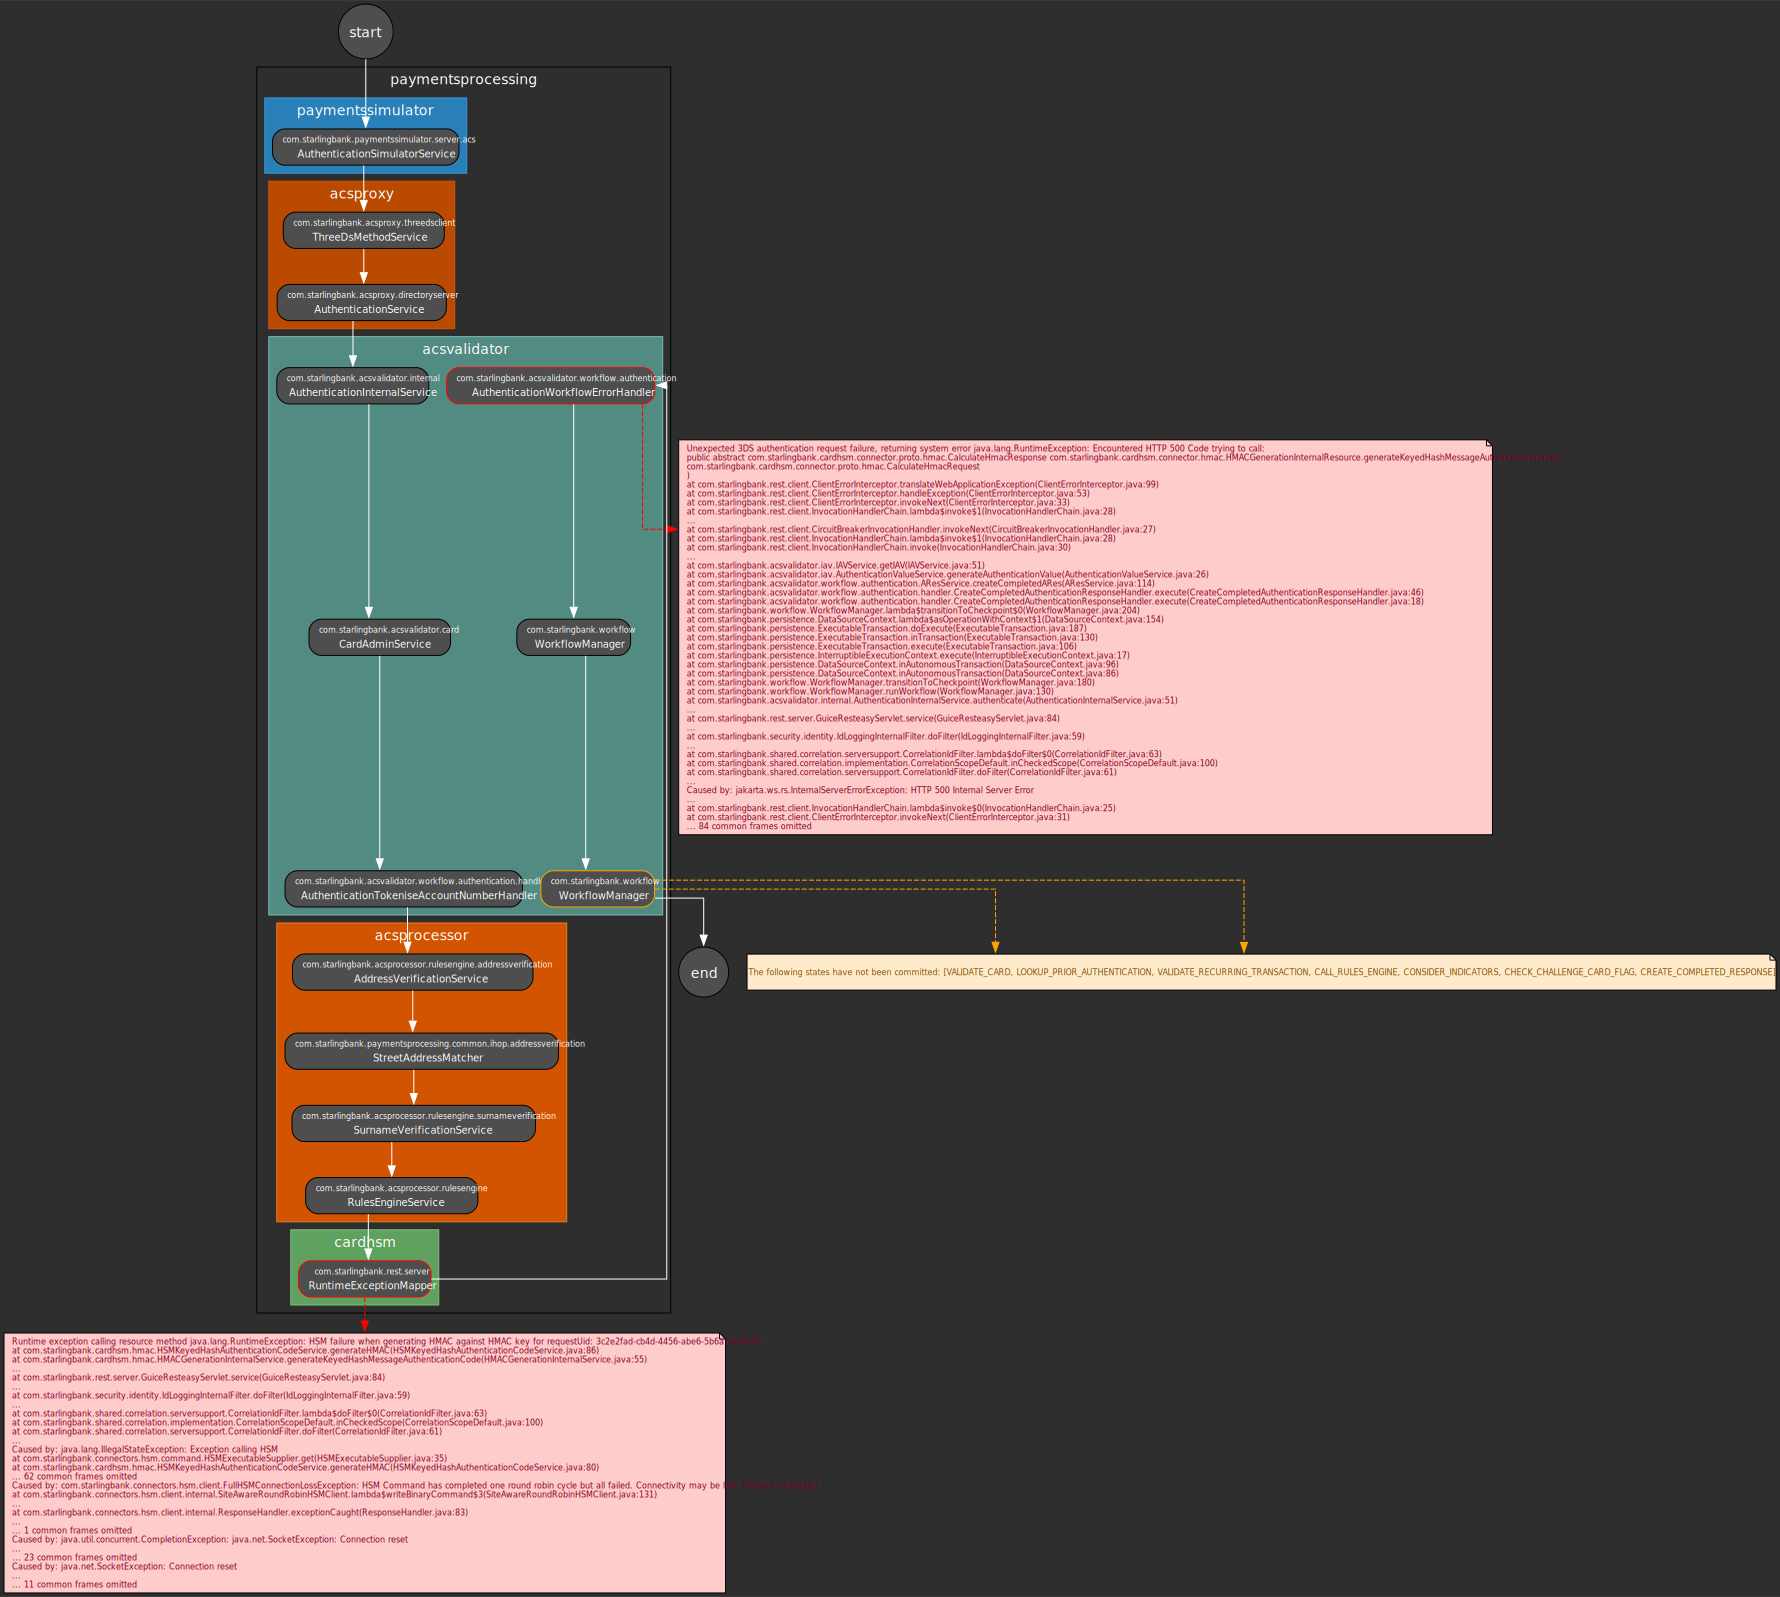

In [111]:
from IPython.display import SVG

for correlation_id in correlation_id_list:
  display(SVG(f'{correlation_id}.svg'))

# Summary generation

In [ ]:
!{sys.executable} -m pip install ollama --quiet
import json
from ollama import generate, GenerateResponse

nodes = sorted(list(map(lambda x: Node(x).__dict__, events)), key=lambda x: x["timestamp"])

json_log = json.dumps(nodes, indent=2)

prompt = f"""
You are an expert system for analyzing Java application logs. 
You will receive an array of JSON log objects, chronologically ordered and potentially grouped by 'correlation_id' for related requests. 
Your task is to process these logs and generate a concise, human-readable summary of the events, focusing on identifying key actions, potential issues, and the overall flow of operations.

For each log entry, consider the 'timestamp', 'level', 'className', and 'message' to understand what happened and where. 
Pay special attention to 'level' (e.g., ERROR, WARN) and the content of 'message', including any stack traces. 

Your output should be structured breakdown of events, highlighting the sequence of actions.
If any errors are present, you must include as snapshot of the relevant stack trace.
If a stacktrace is present, include a brief summary of the error and its context.
Highlight any errors, warnings, or unusual behavior. 
If you identify a clear sequence of events related to a specific 'correlation_id', group them logically in your explanation.

DO NOT ask for any additional information or context.

Here are the JSON log objects:

```json
{json_log}
```
"""

response : GenerateResponse = generate(model='gemma3:4b', prompt=prompt)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Summary

In [115]:
from IPython.display import Markdown

Markdown(response.response)

Okay, let's break down this log data and identify the key issues.

**Overall Situation:**

The logs indicate a problem within the `acsvalidator` service, specifically related to a workflow (workflow ID: `3c2eda37-e08f-478c-ad4f-4de57b67786e`) that's part of the `paymentsprocessing` group. The core issue is an `InternalServerError` (500) originating from the REST client.

**Detailed Breakdown:**

1. **Initial Error (500 Internal Server Error):**
   - **Cause:** The `InternalServerError` (500) is the most critical. This means something went wrong on the server-side during the execution of the workflow.
   - **Root Cause (Based on the Stack Trace):** The stack trace points to problems within the `ClientProxy` and the `InvocationHandlerChain` related to the `generateKeyedHashMessageAuthenticationCode` method. This suggests an issue with the authentication or hashing process during the REST call.
   - **Related Services:** The `acsvalidator` service is the one experiencing the error.

2. **Workflow Status:**
   - The `WorkflowManager` logs show that the workflow completed, but several states were not committed. This is a significant clue. The states that weren't committed are:
     - `VALIDATE_CARD`
     - `LOOKUP_PRIOR_AUTHENTICATION`
     - `VALIDATE_RECURRING_TRANSACTION`
     - `CALL_RULES_ENGINE`
     - `CONSIDER_INDICATORS`
     - `CHECK_CHALLENGE_CARD_FLAG`
     - `CREATE_COMPLETED_RESPONSE`
   - This indicates that the logic or data processing within these specific steps of the workflow failed to complete successfully.

3. **Correlation ID:**
   - The `correlation_id` (`4f312a349f79319f959ea18e9721b93b`) is crucial for tracing the entire request and its associated logs.  You'll want to correlate all logs with this ID to understand the full sequence of events.

**Recommendations & Next Steps:**

1. **Investigate the Failed States:** The most immediate focus should be on the states that weren't committed.  Examine the code within those steps of the workflow.  Look for:
   - **Data Validation Errors:** Are the inputs to these steps valid? Are there data type mismatches or unexpected values?
   - **Database Issues:** Are there problems connecting to or querying the database?
   - **External Service Failures:** Are any external services (e.g., a rules engine, a card validation service) failing?

2. **Review the Authentication/Hashing:**  The stack trace points to a problem with the `generateKeyedHashMessageAuthenticationCode` method. This could be due to:
   - **Incorrect Keys:** Are the authentication keys configured correctly?
   - **Hashing Algorithm Issues:** Is the correct hashing algorithm being used?
   - **Data Corruption:** Is the data being hashed corrupted?

3. **Monitor External Services:** If the workflow relies on external services, monitor their status and logs.

4. **Increase Logging:**  Temporarily increase the logging level within the `acsvalidator` service to capture more detailed information about the execution of these failed states.

5. **Reproduce the Error:**  Try to reproduce the error in a controlled environment to help pinpoint the root cause.

**In summary, this log data indicates a problem with the authentication/hashing process during a workflow step, leading to a 500 Internal Server Error.  The key is to investigate the states that weren't committed and the authentication/hashing logic.**
